In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

path_root = '/home/xingguang/Documents/ECE661/hw10/Task2_Images'

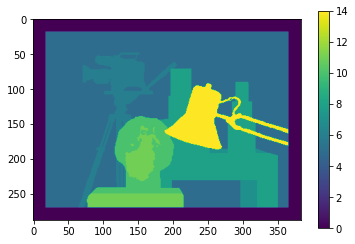

In [30]:
img1 = cv2.imread(os.path.join(path_root, "Left.ppm"), cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(os.path.join(path_root, "Right.ppm"), cv2.IMREAD_GRAYSCALE)
img1_gt = cv2.imread(os.path.join(path_root, "left_truedisp.pgm"),cv2.IMREAD_GRAYSCALE)
img1_gt = (img1_gt.astype(np.float32)/16).astype(np.int)
npixel = img1_gt.shape[0] * img1_gt.shape[1]
plt.figure()
plt.imshow(img1_gt)
plt.colorbar()
plt.savefig("./Task2_output/GT.jpg")

In [7]:
def ConsusTrans(img, M):
    s = (M-1)//2
    x_min, x_max = s, img.shape[1] - 1 - s
    y_min, y_max = s, img.shape[0] - 1 - s
    c = np.transpose([np.tile(np.arange(x_min, x_max,1), y_max-y_min), \
            np.repeat(np.arange(y_min, y_max, 1), x_max-x_min)]) 
    
    pc = img[c[:,1], c[:,0]]
    codes = []
    for x_shift in range(-s, s+1):
        for y_shift in range(-s, s+1):
            pixels = img[c[:,1]+y_shift, c[:,0]+x_shift]
            codes.append(pc < pixels)
    
    codes = np.array(codes)
    img_bits = np.zeros((img.shape[0], img.shape[1],M*M),dtype=np.bool)
    img_bits[c[:,1], c[:,0]] = codes.T
    return img_bits

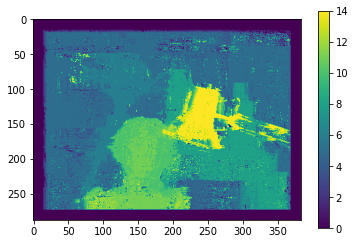

In [28]:
M  =  29
bit_im1 = ConsusTrans(img1, M)
bit_im2 = ConsusTrans(img2, M)

s = (M-1)//2
x_min, x_max = s, bit_im1.shape[1] - 1 - s 
y_min, y_max = s, bit_im1.shape[0] - 1 - s
c = np.transpose([np.tile(np.arange(x_min, x_max,1), y_max-y_min), \
                    np.repeat(np.arange(y_min, y_max, 1), x_max-x_min)]) 

ddis = np.zeros((img1.shape[0], img1.shape[1]))
census_map = -np.inf*np.ones((img1.shape[0], img1.shape[1]))
for sh in range(15):
    # left image, and the right image within a certain shifted ROI
    mask = c[:,1]-sh >=s
    roi1 = c[mask]
    roi2 = c[mask] - np.array([[sh,0]])

    roi1_bits = bit_im1[roi1[:,1], roi1[:,0],:]
    roi2_bits = bit_im2[roi2[:,1], roi2[:,0],:]
    census_ROI = np.sum(roi1_bits==roi2_bits, axis=-1)
    
    census_mask = census_map[roi1[:,1], roi1[:,0]] < census_ROI
    roi2d = roi1[census_mask]
    ddis[roi2d[:,1], roi2d[:,0]] = sh
    census_map[roi2d[:,1], roi2d[:,0]] = census_ROI[census_mask]

plt.figure()
plt.imshow(ddis)
plt.colorbar()
plt.savefig(f"./Task2_output/disparity_{M}.jpg")

percent delta=1, 86.70337818287037
percent delta=2, 90.14756944444444


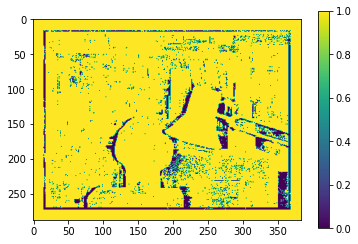

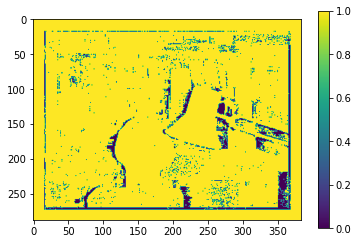

In [29]:
for delta in [1, 2]:
    mask = (disparity_dis-img1_gt)<=delta
    error = np.sum(np.abs((disparity_dis-img1_gt))<=delta)
    print(f"percent delta={delta}," , 100*error/npixel)

    plt.figure()
    plt.imshow(mask)
    plt.colorbar()
    plt.savefig(f"./Task2_output/mask_{delta}_{M}.jpg")